# Baseline Model - Regime-Aware Volatility

We established:
- Log returns are approximately stationary
- Volatility clustering is present
- Market behavior is not structurally constant over long horizons

This notebook focus is on EWMA based volatility forecasting, and regime shift estimation. 

## Import Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# model
from arch import arch_model

In [3]:
# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import itertools

In [4]:
# hide warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
# fix runtime autoclose in collab
import ipykernel
ipykernel.version_info

(6, 29, 5)

## Data Prep

In [6]:
df = yf.download('MSFT', start='2014-01-01', auto_adjust=True, progress=False)
df.dropna(inplace=True)
df['LogReturn'] = np.log(df['Close']).diff()
print("are dates sorted?:", df.index.is_monotonic_increasing)

are dates sorted?: True


In [7]:
df_train, df_test = train_test_split(df, shuffle=False, train_size=0.7)

In [8]:
# is variance modeling actually needed?
std_resid = StandardScaler().fit_transform(df[['LogReturn']].dropna())
from statsmodels.stats.diagnostic import het_arch
lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(std_resid, nlags=12)
print("ARCH test on std resid p-value:", lm_pvalue)

ARCH test on std resid p-value: 2.1347566801848534e-112


ARCH LM null hypothesis assume all coffiecient including the constant is 0. 
p <<< 0.05 conforms that volatility clusters and varying conditional volatility.

## Model Building

In [16]:
# target window
TARGET = 1 # in days

# scaling for numeric stability 
r_pct = df['LogReturn'].dropna() * 100 

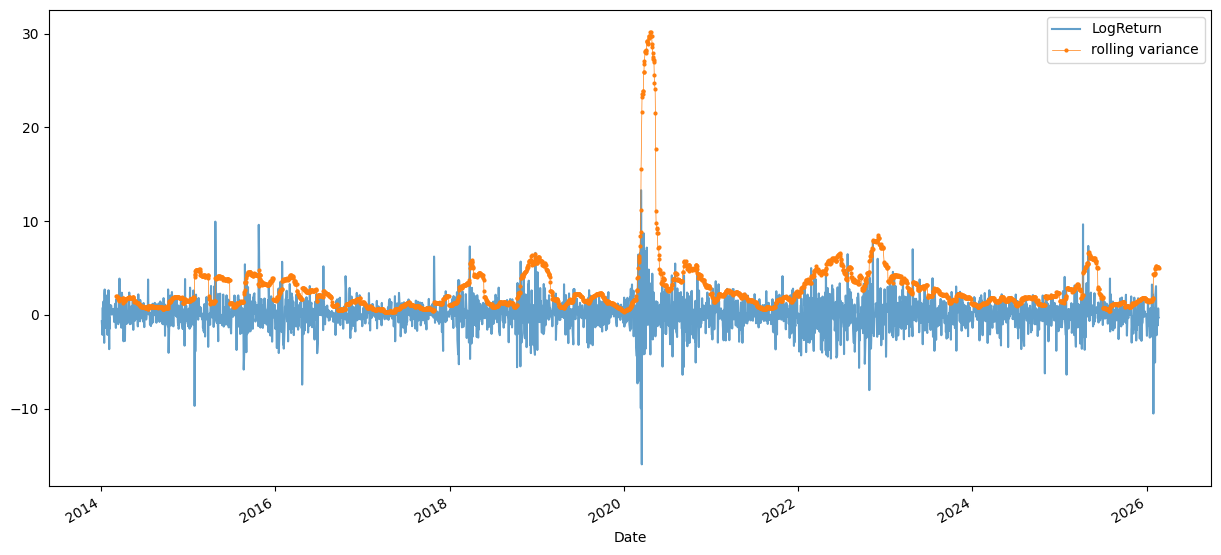

In [10]:
plt.figure(figsize=(15, 7))
(r_pct).plot(legend=True, alpha=0.7)
#(r_pct ** 2).plot(legend=True, label='variance')
(r_pct).rolling(42).var().plot(legend=True, label='rolling variance', 
                               marker='o', markersize=2, linewidth=0.5)
plt.show()

GARCH might perform better.

In [11]:
target = 1 # volatility 1 day ahead

In [26]:
np.round(r_pct.mean(), 4)

np.float64(0.0838)

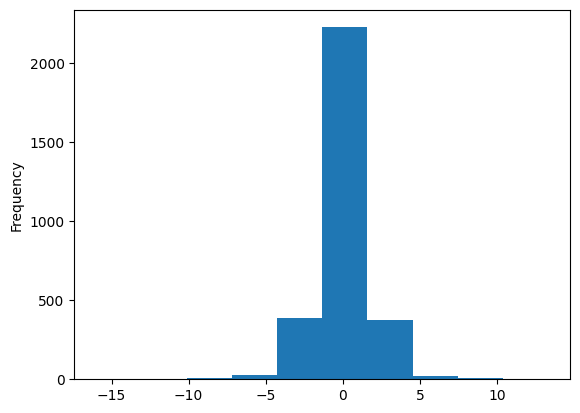

In [29]:
r_pct.plot(kind='hist');

In [33]:
models = pd.DataFrame(columns=['model', 'aic', 'bic', 'lik'])

# p and q are considered with help from squared return ACF plot
for p, q in itertools.product([1, 2, 5, 15], repeat=2):
    arch_fit = arch_model(r_pct.values, mean="Zero", vol='ARCH', p=p, dist='normal').fit(disp='off')
    garch_fit = arch_model(r_pct.values, mean='Zero', vol='GARCH', p=p, q=q, dist='normal').fit(disp='off')
    
    models.loc[f'arch{p}'] = arch_fit, arch_fit.aic, arch_fit.bic, arch_fit.loglikelihood
    models.loc[f'g{q}arch{p}'] = garch_fit, garch_fit.aic, garch_fit.bic, garch_fit.loglikelihood
    
    print("done: ", p, q)
    

done:  1 1
done:  1 2
done:  1 5
done:  1 15
done:  2 1
done:  2 2
done:  2 5
done:  2 15
done:  5 1
done:  5 2
done:  5 5
done:  5 15
done:  15 1
done:  15 2
done:  15 5
done:  15 15


In [39]:
models['aic'].argmin()

np.int64(15)

In [36]:
models['bic'].argmin()


np.int64(1)

The AIC BIC are very high, nowhere close to 1 - meaning the model are worse than 

In [21]:
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

def diag(res, lags=20):
    # standardized residuals
    z = res.std_resid.dropna()

    lb_z = acorr_ljungbox(z, lags=[lags], return_df=True)
    lb_z2 = acorr_ljungbox(z**2, lags=[lags], return_df=True)

    # Engle ARCH LM on standardized residuals
    arch_lm = het_arch(z, nlags=lags)  # returns (LM stat, LM pval, F stat, F pval)

    return {
        "LjungBox z pval": float(lb_z["lb_pvalue"].iloc[0]),
        "LjungBox z^2 pval": float(lb_z2["lb_pvalue"].iloc[0]),
        "ARCH LM pval": float(arch_lm[1]),
    }

for name, res in models.items():
    print(name, diag(res, lags=20))


ARCH(1) {'LjungBox z pval': 0.0029704815872935724, 'LjungBox z^2 pval': 1.5517298895162623e-22, 'ARCH LM pval': 7.236779217405447e-13}
ARCH(5) {'LjungBox z pval': 0.19550989642853417, 'LjungBox z^2 pval': 0.7430591912940578, 'ARCH LM pval': 0.7265308526823129}
GARCH(1,1) {'LjungBox z pval': 0.24863951971446263, 'LjungBox z^2 pval': 0.9516727893896644, 'ARCH LM pval': 0.9459375199136096}
GARCH(2,1) {'LjungBox z pval': 0.24840355584553622, 'LjungBox z^2 pval': 0.9474372790460498, 'ARCH LM pval': 0.9428114212632708}
GARCH(1,2) {'LjungBox z pval': 0.24864236943226012, 'LjungBox z^2 pval': 0.951669493555462, 'ARCH LM pval': 0.9459316178443711}
